<a href="https://colab.research.google.com/github/WillHBX/PM2.5-forecasting-based-on-attention-based-LSTM-neural-network/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import os

from sklearn.metrics import mean_squared_error

from math import sqrt
import time

from pickle import dump, load, HIGHEST_PROTOCOL
import matplotlib.pyplot as plt



from keras.models import Model
from keras.layers import Dense
from keras.layers import multiply
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import load_model

## Functions

In [ ]:

def persistent(dataType, X_test, y_test):
    test_rmse = list()
    y_hat = [sample[-1][0] for sample in X_test]
    
    rmse = sqrt(mean_squared_error(y_test, y_hat))

    print('%s RMSE: %0.4f' % (dataType,rmse))
    return None

def XGBoost(X_train, y_train, X_test, y_test, X_validation, y_validation):
    import xgboost as xgb
    
    param = {'max_depth':6, 'objective':'reg:linear'}
    train_rmse, validation_rmse, test_rmse = list(), list(), list()
    yhat_train, yhat_validation, yhat_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for i in range(1):
        y_train_, y_validation_, y_test_ = y_train, y_validation, y_test
        
        d_train = xgb.DMatrix(X_train, y_train_)
        d_validation = xgb.DMatrix(X_validation, y_validation_)
        d_test = xgb.DMatrix(X_test, y_test_)
        XGB = xgb.train(param, d_train)
        
        y_hat = XGB.predict(d_train)
        yhat_train['%d'%(i+1)] = y_hat
        y = y_train_
        rmse = sqrt(mean_squared_error(y, y_hat))
        train_rmse.append(rmse)
        
        y_hat = XGB.predict(d_validation)
        yhat_validation['%d'%(i+1)] = y_hat
        y = y_validation_
        rmse = sqrt(mean_squared_error(y, y_hat))
        validation_rmse.append(rmse)
        
        y_hat = XGB.predict(d_test)
        yhat_test['%d'%(i+1)] = y_hat
        y = y_test_
        rmse = sqrt(mean_squared_error(y, y_hat))
        test_rmse.append(rmse)
    
    for i in range(len(train_rmse)):
        print('Train RMSE(%d): %0.4f' % (i+1, train_rmse[i]))
    for i in range(len(validation_rmse)):
        print('Validation RMSE(%d): %0.4f' % (i+1, validation_rmse[i]))
    for i in range(len(test_rmse)):
        print('Test RMSE(%d): %0.4f' % (i+1, test_rmse[i]))
        
    return yhat_train.values, yhat_validation.values, yhat_test.values

def linear_regression(X_train, y_train, X_test, y_test, X_validation, y_validation):
    from sklearn.linear_model import LinearRegression
    
    train_rmse, validation_rmse, test_rmse = list(), list(), list()
    yhat_train, yhat_validation, yhat_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for i in range(1):
        y_train_, y_validation_, y_test_ = y_train, y_validation, y_test
        
        LR = LinearRegression()
        LR.fit(X_train, y_train_)
        
        y_hat = LR.predict(X_train)
        yhat_train['%d'%(i+1)] = y_hat
        y = y_train_
        rmse = sqrt(mean_squared_error(y, y_hat))
        train_rmse.append(rmse)
        
        y_hat = LR.predict(X_validation)
        yhat_validation['%d'%(i+1)] = y_hat
        y = y_validation_
        rmse = sqrt(mean_squared_error(y, y_hat))
        validation_rmse.append(rmse)
        
        y_hat = LR.predict(X_test)
        yhat_test['%d'%(i+1)] = y_hat
        y = y_test_
        rmse = sqrt(mean_squared_error(y, y_hat))
        test_rmse.append(rmse)
    
    for i in range(len(train_rmse)):
        print('Train RMSE(%d): %0.4f' % (i+1, train_rmse[i]))
    for i in range(len(validation_rmse)):
        print('Validation RMSE(%d): %0.4f' % (i+1, validation_rmse[i]))
    for i in range(len(test_rmse)):
        print('Test RMSE(%d): %0.4f' % (i+1, test_rmse[i]))
        
    return yhat_train.values, yhat_validation.values, yhat_test.values

def MLP_regression(X_train, y_train, X_test, y_test, X_validation, y_validation):
    from sklearn.neural_network import MLPRegressor
    
    train_rmse, validation_rmse, test_rmse = list(), list(), list()
    yhat_train, yhat_validation, yhat_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for i in range(1):
        y_train_, y_validation_, y_test_ = y_train, y_validation, y_test
        
        MLP = MLPRegressor(hidden_layer_sizes=120)
        MLP.fit(X_train, y_train_)
        
        y_hat_train = MLP.predict(X_train)
        yhat_train['%d'%(i+1)] = y_hat_train
        y = y_train_
        rmse = sqrt(mean_squared_error(y, y_hat_train))
        train_rmse.append(rmse)
        
        y_hat_validation = MLP.predict(X_validation)
        yhat_validation['%d'%(i+1)] = y_hat_validation
        y = y_validation_
        rmse = sqrt(mean_squared_error(y, y_hat_validation))
        validation_rmse.append(rmse)
        
        y_hat_test = MLP.predict(X_test)
        yhat_test['%d'%(i+1)] = y_hat_test
        y = y_test_
        rmse = sqrt(mean_squared_error(y, y_hat_test))
        test_rmse.append(rmse)
    
    for i in range(len(train_rmse)):
        print('Train RMSE(%d): %0.4f' % (i+1, train_rmse[i]))
    for i in range(len(validation_rmse)):
        print('Validation RMSE(%d): %0.4f' % (i+1, validation_rmse[i]))
    for i in range(len(test_rmse)):
        print('Test RMSE(%d): %0.4f' % (i+1, test_rmse[i]))
        
    return yhat_train.values, yhat_validation.values, yhat_test.values
    
def lstm_seq_to_scalar(X_train, y_train, X_test, y_test, X_validation, y_validation,n_inputs):
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras import regularizers
    
    n_outputs =1
    
    epochs = 5
    batch_size = 64
    layer = 108
    n_features = 8

    
    train_rmse, validation_rmse, test_rmse = list(), list(), list()
    for i in range(1):
        y_train_, y_validation_, y_test_ = y_train, y_validation, y_test
            
        train_y_ = y_train_.reshape((y_train_.shape[0], 1))
        validation_y = y_validation_.reshape((y_validation_.shape[0], 1))
        test_y = y_test_.reshape((y_test_.shape[0], 1))
        
        model = Sequential()
        model.add(LSTM(layer, input_shape=(n_inputs, n_features)))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        
        #print(model.summary())
        
        history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
        
        yhat = model.predict(X_train)
        yhat = yhat.reshape((yhat.shape[0], 1))
        #yhat = y_scaler.inverse_transform(yhat)
        
        y = y_train_
        
        rmse = sqrt(mean_squared_error(y, yhat))
        train_rmse.append(rmse)
        
        yhat = model.predict(X_validation)
        yhat = yhat.reshape((yhat.shape[0], 1))
        #yhat = y_scaler.inverse_transform(yhat)
        
        y = y_validation_
        
        rmse = sqrt(mean_squared_error(y, yhat))
        validation_rmse.append(rmse)
            
        yhat = model.predict(X_test)
        yhat = yhat.reshape((yhat.shape[0], 1))
        #yhat = y_scaler.inverse_transform(yhat)
        
        y = y_test_
        
        rmse = sqrt(mean_squared_error(y, yhat))
        test_rmse.append(rmse)
        
    for i in range(len(train_rmse)):
        print('Train RMSE(%d): %0.4f' % (i+1, train_rmse[i]))
    for i in range(len(validation_rmse)):
        print('Validation RMSE(%d): %0.4f' % (i+1, validation_rmse[i]))
    for i in range(len(test_rmse)):
        print('Test RMSE(%d): %0.4f' % (i+1, test_rmse[i]))
            
    '''
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    '''
    
    return None



## 開始

In [ ]:
path = "/content/drive/MyDrive/大專生科技部計畫/data/samples/"
fileList = os.listdir(path)
data = dict()
for file in fileList:
  if file[-1] != 'y':
    data[file[:-4]] = pd.DataFrame(np.load(path+file)['data'])

for i in data.keys():
  print(i)


2020_pm25_data
2020_target_wind_data
2021_target_wind_data
2019_pm25_data
2019_target_wind_data
2018_target_wind_data
2021_pm25_data
2018_pm25_data
2018_rain_data
2019_rain_data
2020_rain_data
2021_rain_data


In [ ]:
def gen_samples(seq, size, timesteps):
  X = np.array([seq[i:i+size] for i in range(seq.shape[0]-size-timesteps)])
  y = np.array([seq[size+i+timesteps][0] for i in range(seq.shape[0]-size-timesteps)])
  return X, y

In [ ]:
# train_X: (#samples, 8(小時)size, 8(wind)/9(pm2.5))
hours_wind = 8
hours_rain = 8
hours_pm25 = 8
timesteps = 6


# train     2018 2019
train_wind = pd.concat([data['2018_target_wind_data'],data['2019_target_wind_data']]).values
train_wind,_ = gen_samples(train_wind, hours_wind, timesteps) 

train_rain = pd.concat([data['2018_rain_data'].iloc[:,:-1],data['2019_rain_data'].iloc[:,:-1]]).values
train_rain, _ = gen_samples(train_rain, hours_rain, timesteps)

train_pm25 = pd.concat([data['2018_pm25_data'].iloc[:,:-1],data['2019_pm25_data'].iloc[:,:-1]]).values
train_pm25, train_target = gen_samples(train_pm25, hours_pm25, timesteps)


# validation   2020 
validation_wind = data['2020_target_wind_data'].values
validation_wind,_ = gen_samples(validation_wind, hours_wind, timesteps) 

validation_rain = data['2020_rain_data'].iloc[:,:-1].values
validation_rain, _ = gen_samples(validation_rain, hours_rain, timesteps)

validation_pm25 = data['2020_pm25_data'].iloc[:,:-1].values
validation_pm25, validation_target = gen_samples(validation_pm25, hours_pm25, timesteps)

# test      2021 
test_wind = data['2021_target_wind_data'].values
test_wind,_ = gen_samples(test_wind, hours_wind, timesteps) 

test_rain = data['2021_rain_data'].iloc[:,:-1].values
test_rain, _ = gen_samples(test_rain, hours_rain, timesteps)

test_pm25 = data['2021_pm25_data'].iloc[:,:-1].values
test_pm25, test_target = gen_samples(test_pm25, hours_pm25, timesteps)

# [sample[1][0] for sample in train_pm25] 拿全部的第一筆
persistent('Train', train_pm25, train_target)
persistent('Validation', validation_pm25, validation_target)
persistent('Test', test_pm25, test_target)



Train RMSE: 10.5441
Validation RMSE: 7.0559
Test RMSE: 7.7535


## Wind-attention LSTM


In [ ]:
t = time.time()
    
pm25Input = Input(shape=(hours_pm25, 8), name='pm25_input')
pm25enc = LSTM(12, return_sequences=True)(pm25Input)
#pm25enc = Dropout(0.3)(pm25enc)
    
windInput = Input(shape=(hours_wind, 8), name='wind_input')
windenc = LSTM(12, return_sequences=True)(windInput)
#windenc = Dropout(0.3)(windenc)
    
att = multiply([windenc, pm25enc])
att = Flatten()(att)
att = Dense(hours_pm25 * 8, activation='sigmoid')(att)
att = Reshape((hours_pm25, 8))(att)
    
    
m = multiply([att, pm25Input])
m = Flatten()(m)
pm25Output = Dense(1)(m)
    
model = Model(inputs=[pm25Input, windInput], outputs=[pm25Output])
model.compile(optimizer='adam', loss='mse')
    
callBack = EarlyStopping(monitor='val_loss', patience=4)
    
history = model.fit([train_pm25, train_wind], [train_target], 
                        validation_data=([validation_pm25, validation_wind], [validation_target]), 
                        epochs=32 , batch_size=64, verbose=0, shuffle=False, callbacks=[callBack])
    
print('Total %f seconds.'%(time.time() - t))

model.save('/content/drive/MyDrive/大專生科技部計畫/models/lstm_wind_att_model.h5')
del model

Total 50.491002 seconds.


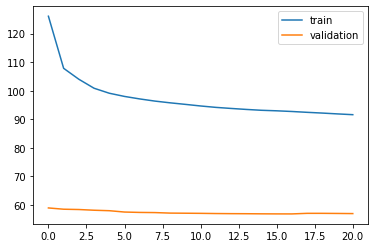

547/547 [==============================] - 3s 3ms/step
Train RMSE(1): 9.4693
274/274 [==============================] - 1s 3ms/step
Validation RMSE(1): 7.5467
273/273 [==============================] - 1s 3ms/step
Test RMSE(1): 8.4960


In [ ]:
model = load_model('/content/drive/MyDrive/大專生科技部計畫/models/lstm_wind_att_model.h5')
    
#Plot
    
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()
    
#Evaluation
    
yhat_train = model.predict([train_pm25, train_wind])
# yhat_train = yhat_train.reshape((yhat_train.shape[0], n_targets))
    
y = train_target
    
for i in range(yhat_train.shape[1]):
    rmse = sqrt(mean_squared_error(y, yhat_train))
    print('Train RMSE(%d): %0.4f' % (i+1, rmse))
        
yhat_validation = model.predict([validation_pm25, validation_wind])
# yhat_validation = yhat_validation.reshape((yhat_validation.shape[0], n_targets))
    
y = validation_target
    
for i in range(yhat_validation.shape[1]):
    rmse = sqrt(mean_squared_error(y, yhat_validation))
    print('Validation RMSE(%d): %0.4f' % (i+1, rmse))
        
yhat_test = model.predict([test_pm25, test_wind])
# yhat_test = yhat_test.reshape((yhat_test.shape[0], n_targets))
    
y = test_target
    
for i in range(yhat_test.shape[1]):
    rmse = sqrt(mean_squared_error(y, yhat_test))
    print('Test RMSE(%d): %0.4f' % (i+1, rmse))

## Rainfall-attention LSTM


In [ ]:
t = time.time()
    
pm25Input = Input(shape=(hours_pm25, 8), name='pm25_input')
pm25enc = LSTM(12, return_sequences=True)(pm25Input)

    
rainInput = Input(shape=(hours_rain, 8), name='rain_input')
rainenc = LSTM(12, return_sequences=True)(rainInput)

    
att = multiply([rainenc, pm25enc])
att = Flatten()(att)
att = Dense(hours_pm25 * 8, activation='sigmoid')(att)
att = Reshape((hours_pm25, 8))(att)
    
    
m = multiply([att, pm25Input])
m = Flatten()(m)
pm25Output = Dense(1)(m)
    
model = Model(inputs=[pm25Input, rainInput], outputs=[pm25Output])
model.compile(optimizer='adam', loss='mse')
    
callBack = EarlyStopping(monitor='val_loss', patience=4)
    
history = model.fit([train_pm25, train_rain], [train_target], 
                        validation_data=([validation_pm25, validation_rain], [validation_target]), 
                        epochs=32 , batch_size=64, verbose=0, shuffle=False, callbacks=[callBack])
    
print('Total %f seconds.'%(time.time() - t))

model.save('/content/drive/MyDrive/大專生科技部計畫/models/lstm_rain_att_model.h5')
del model

Total 67.840464 seconds.


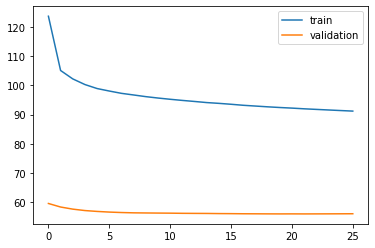

547/547 [==============================] - 2s 3ms/step
Train RMSE(1): 9.4941
274/274 [==============================] - 1s 3ms/step
Validation RMSE(1): 7.4883
273/273 [==============================] - 1s 3ms/step
Test RMSE(1): 8.4329


In [ ]:
model = load_model('/content/drive/MyDrive/大專生科技部計畫/models/lstm_rain_att_model.h5')
    
#Plot
    
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()
    
#Evaluation
    
yhat_train = model.predict([train_pm25, train_rain])
# yhat_train = yhat_train.reshape((yhat_train.shape[0], n_targets))
    
y = train_target
    
for i in range(yhat_train.shape[1]):
    rmse = sqrt(mean_squared_error(y, yhat_train))
    print('Train RMSE(%d): %0.4f' % (i+1, rmse))
        
yhat_validation = model.predict([validation_pm25, validation_rain])
# yhat_validation = yhat_validation.reshape((yhat_validation.shape[0], n_targets))
    
y = validation_target
    
for i in range(yhat_validation.shape[1]):
    rmse = sqrt(mean_squared_error(y, yhat_validation))
    print('Validation RMSE(%d): %0.4f' % (i+1, rmse))
        
yhat_test = model.predict([test_pm25, test_rain])
# yhat_test = yhat_test.reshape((yhat_test.shape[0], n_targets))
    
y = test_target
    
for i in range(yhat_test.shape[1]):
    rmse = sqrt(mean_squared_error(y, yhat_test))
    print('Test RMSE(%d): %0.4f' % (i+1, rmse))

## WR-attention LSTM

In [ ]:
t = time.time()
    
pm25Input = Input(shape=(hours_pm25, 8), name='pm25_input')
pm25enc = LSTM(12, return_sequences=True)(pm25Input)

    
rainInput = Input(shape=(hours_rain, 8), name='rain_input')
rainenc = LSTM(12, return_sequences=True)(rainInput)

windInput = Input(shape=(hours_wind, 8), name='wind_input')
windenc = LSTM(12, return_sequences=True)(windInput)
    
r_att = multiply([rainenc, pm25enc])
r_att = Flatten()(r_att)
r_att = Dense(hours_pm25 * 8, activation='sigmoid')(r_att)
r_att = Reshape((hours_pm25, 8))(r_att)

w_att = multiply([windenc, pm25enc])
w_att = Flatten()(w_att)
w_att = Dense(hours_pm25 * 8, activation='sigmoid')(w_att)
w_att = Reshape((hours_pm25, 8))(w_att)

att = multiply([r_att,w_att])
att = Flatten()(att)
att = Dense(hours_pm25 * 8, activation='sigmoid')(att)
att = Reshape((hours_pm25, 8))(att)

m = multiply([att, pm25Input])
m = Flatten()(m)
pm25Output = Dense(1)(m)
    
model = Model(inputs=[pm25Input, rainInput, windInput], outputs=[pm25Output])
model.compile(optimizer='adam', loss='mse')
    
callBack = EarlyStopping(monitor='val_loss', patience=4)
    
history = model.fit([train_pm25, train_rain, train_wind], [train_target], 
                        validation_data=([validation_pm25, validation_rain, validation_wind], [validation_target]), 
                        epochs=32 , batch_size=64, verbose=0, shuffle=False, callbacks=[callBack])
    
print('Total %f seconds.'%(time.time() - t))

model.save('/content/drive/MyDrive/大專生科技部計畫/models/lstm_wr_att_model.h5')
del model

Total 87.085855 seconds.


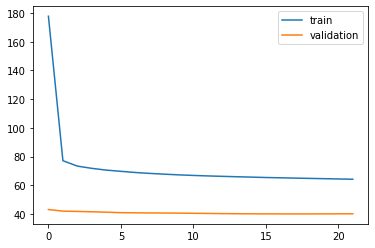

548/548 [==============================] - 4s 4ms/step
Train RMSE(1): 7.8237
275/275 [==============================] - 1s 4ms/step
Validation RMSE(1): 6.3324
274/274 [==============================] - 1s 4ms/step
Test RMSE(1): 6.8553


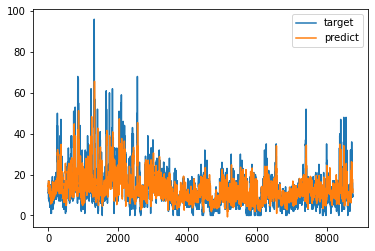

In [ ]:
model = load_model('/content/drive/MyDrive/大專生科技部計畫/models/lstm_wr_att_model.h5')
    
#Plot
    
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()
    
#Evaluation
    
yhat_train = model.predict([train_pm25, train_rain, train_wind])
# yhat_train = yhat_train.reshape((yhat_train.shape[0], n_targets))
    
y = train_target
    
for i in range(yhat_train.shape[1]):
    rmse = sqrt(mean_squared_error(y, yhat_train))
    print('Train RMSE(%d): %0.4f' % (i+1, rmse))
        
yhat_validation = model.predict([validation_pm25, validation_rain, validation_wind])
# yhat_validation = yhat_validation.reshape((yhat_validation.shape[0], n_targets))
    
y = validation_target
    
for i in range(yhat_validation.shape[1]):
    rmse = sqrt(mean_squared_error(y, yhat_validation))
    print('Validation RMSE(%d): %0.4f' % (i+1, rmse))
        
yhat_test = model.predict([test_pm25, test_rain, test_wind])
# yhat_test = yhat_test.reshape((yhat_test.shape[0], n_targets))
    
y = test_target
    
for i in range(yhat_test.shape[1]):
    rmse = sqrt(mean_squared_error(y, yhat_test))

    print('Test RMSE(%d): %0.4f' % (i+1, rmse))


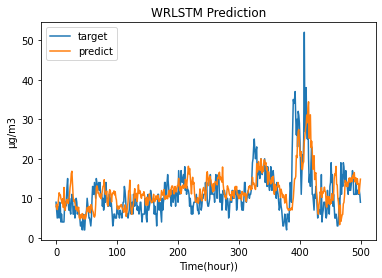

In [ ]:
plt.plot(test_target[7000:7500], label='target')
plt.plot(yhat_test[7000:7500], label='predict')
plt.xlabel('Time(hour))')
plt.ylabel('μg/m3')
plt.title('WRLSTM Prediction')
plt.legend()
plt.show()
    

## LR


In [ ]:
lstm_seq_to_scalar(train_pm25, train_target, test_pm25, test_target, validation_pm25, validation_target,hours_wind)

273/273 [==============================] - 1s 4ms/step
Train RMSE(1): 9.7269
Validation RMSE(1): 7.3838
Test RMSE(1): 8.2767


In [ ]:
trainX = [[train_pm25[j][i][0] for i in range(len(train_pm25[0]))] for j in range(len(train_pm25))]
testX = [[test_pm25[j][i][0] for i in range(len(test_pm25[0]))] for j in range(len(test_pm25))]
validationX = [[validation_pm25[j][i][0] for i in range(len(validation_pm25[0]))] for j in range(len(validation_pm25))]
# MLP_regression(trainX, train_target, testX, test_target, validationX, validation_target)

In [ ]:
XGBoost(trainX, train_target, testX, test_target, validationX, validation_target)

[14:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE(1): 8.5261
Validation RMSE(1): 6.4119
Test RMSE(1): 7.0973


(array([[17.945536],
        [20.054272],
        [19.369207],
        ...,
        [13.336376],
        [15.536545],
        [16.847046]], dtype=float32), array([[ 9.607288],
        [11.318238],
        [ 9.159833],
        ...,
        [13.71226 ],
        [14.944186],
        [14.958016]], dtype=float32), array([[12.752142],
        [12.829605],
        [10.971017],
        ...,
        [11.957601],
        [12.010204],
        [15.30043 ]], dtype=float32))

In [ ]:
linear_regression(trainX, train_target, testX, test_target, validationX, validation_target)

Train RMSE(1): 9.5407
Validation RMSE(1): 7.1576
Test RMSE(1): 8.1415


(array([[15.48649116],
        [14.60688129],
        [15.34793063],
        ...,
        [10.6331038 ],
        [10.4888762 ],
        [10.36225207]]), array([[11.76694349],
        [12.3368307 ],
        [11.46335374],
        ...,
        [15.41595048],
        [15.04425936],
        [14.50482966]]), array([[13.93487988],
        [13.26238473],
        [12.8287995 ],
        ...,
        [19.03520823],
        [17.50363586],
        [16.52416358]]))